## Pseudobulk analysis for cluster marker genes and relevant visualizaitons
## Fan Zhang
## 2021-08-17

In [3]:
library(magrittr)
library(gridExtra)
library(MASS)
library(ggplot2)
library(Matrix)
library(dplyr)
library(rpart)
library(glmnet)
library(data.table)
library(presto)
library(singlecellmethods)
library(illuminaHumanv3.db)
library(lmerTest)
library(irlba)
library(uwot)
library(parallel)
library(lme4)
library(DESeq2)
library(edgeR)
library(reticulate)
library(ggbeeswarm)
library(ggrepel)
library(plyr)
library(ggthemes)
library(RColorBrewer)
library(matrixStats)
library(viridis)
library(grid)
library(Seurat)
library(harmony)
library(scico) 
library(ComplexHeatmap)
library(ggrastr)

meta_colors = list(

 "cell_type" = c(
       "B cell" = "#A65628",
        "Fibroblast" = "#A6CEE3",
        "Endothelial" = "#1F78B4",
        "Myeloid" = "#FB8072",
        "T cell" = "#CAB2D6",
        "NK" = "#6A3D9A"
     ),
    
    "CTAP" = c(
        "M" = "#9E0142",
        "TM" = "#F46D43",
        "TB" = "#FEE08B",
        "TF" = "#E6F598",
        "F" = "#ABDDA4",
        "EFM" = "#66C2A5",
        "OA" = "grey"
    ) 
)


In [3]:
cosine_normalize <- function(X, MARGIN = 1, do_safe = TRUE) {
    if (do_safe) {
        X <- sweep(X, MARGIN, apply(X, MARGIN, max), "/")
    }
    sweep(X, MARGIN, apply(X, MARGIN, function(x) sqrt(sum(x^2))), "/")
}

plot_shuffled_features <- function(ab, umap, exprs, pct = 0.95) {
    max.cutoff = quantile(exprs[ab,], pct)
    min.cutoff = quantile(exprs[ab,], 1-pct)
    tmp <- sapply(X = exprs[ab,], FUN = function(x) {
        return(ifelse(test = x > max.cutoff, yes = max.cutoff,
            no = x))
    })
    tmp <- sapply(X = tmp, FUN = function(x) {
        return(ifelse(test = x < min.cutoff, yes = min.cutoff,
            no = x))
    })
    umap_res_plot <- cbind(umap, tmp)
    return(ggplot(data = as.data.frame(umap_res_plot)[sample(nrow(umap_res_plot)),] , aes(x = V1, y = V2)) +
      geom_point(mapping = aes(color = tmp), shape = ".") +
      scale_color_viridis(option = "plasma", end = .9) +
      theme_classic() +
      theme(legend.position = "none", axis.text = element_blank(), axis.title = element_blank()) +
      labs(title = ab))
}
                           

FindVariableGenesBatch <- function(exprs_mat, meta_df, genes_exclude = NULL, ngenes_use = 1e3, expr_min = .1) {
    if (!is.null(genes_exclude)) {
        genes_use <- setdiff(row.names(exprs_mat), genes_exclude)
    }
    x_res <- split(meta_df$cell, meta_df$sample) %>% lapply(function(x) {
        FindVariableGenesSeurat(exprs_mat[genes_use, x]) %>% 
            subset(gene.mean >= expr_min) %>% 
            tibble::rownames_to_column("gene") %>% 
            dplyr::arrange(-gene.dispersion) %>%
            head(ngenes_use)
    })
    data.table(Reduce(rbind, x_res))[, .N, by = gene][order(-N)]    
}



FindVariableGenesSeurat <- function (data, x.low.cutoff = 0.1, x.high.cutoff = 8,
                                     y.cutoff = 1, y.high.cutoff = Inf, num.bin = 0,
                                     binning.method = "equal_width", sort.results = TRUE,
                                     display.progress = TRUE, ...)
{
    genes.use <- rownames(data)
    if (class(data) != "dgCMatrix") {
        data <- as(as.matrix(data), "dgCMatrix")
    }
    ## (1) get means and variances
    gene.mean <- FastExpMean(data, display.progress)
    names(gene.mean) <- genes.use
    gene.dispersion <- FastLogVMR(data, display.progress)
    names(gene.dispersion) <- genes.use

    gene.dispersion[is.na(x = gene.dispersion)] <- 0
    gene.mean[is.na(x = gene.mean)] <- 0

    mv.df <- data.frame(gene.mean, gene.dispersion)
    rownames(mv.df) <- rownames(data)

    ## (OPTIONAL) do the binning correction
    if (num.bin > 0) {
      if (binning.method == "equal_width") {
          data_x_bin <- cut(x = gene.mean, breaks = num.bin)
      }
      else if (binning.method == "equal_frequency") {
          data_x_bin <- cut(x = gene.mean, breaks = c(-1, quantile(gene.mean[gene.mean >
              0], probs = seq(0, 1, length.out = num.bin))))
     }
      else {
          stop(paste0("Invalid selection: '", binning.method,
              "' for 'binning.method'."))
      }
      names(x = data_x_bin) <- names(x = gene.mean)
      mean_y <- tapply(X = gene.dispersion, INDEX = data_x_bin,
          FUN = mean)
      sd_y <- tapply(X = gene.dispersion, INDEX = data_x_bin,
          FUN = sd)
      gene.dispersion.scaled <- (gene.dispersion - mean_y[as.numeric(x = data_x_bin)])/sd_y[as.numeric(x = data_x_bin)]
      gene.dispersion.scaled[is.na(x = gene.dispersion.scaled)] <- 0
      ##names(gene.dispersion.scaled) <- names(gene.mean)

      mv.df$gene.dispersion.scaled <- gene.dispersion.scaled
    }

    return(mv.df)
}

environment(FindVariableGenesSeurat) <- asNamespace("Seurat")

ScaleDataSeurat <- function (data.use, margin = 1, scale.max = 10,
                                block.size = 1000) {

    if (margin == 2) data.use %<>% t
    max.block <- ceiling(nrow(data.use)/block.size)

    ## Define data and functions to use in sparse and dense cases
    if (class(data.use) == "dgCMatrix" | class(data.use) == "dgTMatrix") {
        scale_fxn <- function(x) {
            FastSparseRowScale(mat = x, scale = TRUE, center = TRUE,
                               scale_max = scale.max, display_progress = FALSE)
        }
    } else {
        scale_fxn <- function(x) {
            FastRowScale(mat = x, scale = TRUE, center = TRUE,
                               scale_max = scale.max, display_progress = FALSE)
       }
        data.use <- as.matrix(data.use)
    }

    ## Do scaling, at once or in chunks
    if (max.block == 1) {
        scaled.data <- scale_fxn(data.use)
    } else {
        scaled.data <- matrix(NA, nrow(data.use), ncol(data.use))
        for (i in 1:max.block) {
            idx.min <- (block.size * (i - 1))
            idx.max <- min(nrow(data.use), (block.size * i - 1) + 1)
            my.inds <- idx.min:idx.max
            scaled.data[my.inds, ] <- scale_fxn(data.use[my.inds, , drop = F])
        }
    }

    colnames(scaled.data) <- colnames(data.use)
    row.names(scaled.data) <- row.names(data.use)
    scaled.data[is.na(scaled.data)] <- 0
    if (margin == 2) scaled.data %<>% t
    return(scaled.data)
}
environment(ScaleDataSeurat) <- asNamespace("Seurat")


fig.size <- function(height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}

SingleFeaturePlotSeurat <- function (data.use, feature, data.plot, pt.size, pch.use, cols.use,
    dim.codes, min.cutoff, max.cutoff, coord.fixed, no.axes,
    no.title = FALSE, no.legend, dark.theme, vector.friendly = FALSE,
    png.file = NULL, png.arguments = c(10, 10, 100))
{
    if (vector.friendly) {
        previous_call <- blank_call <- png_call <- match.call()
        blank_call$pt.size <- -1
        blank_call$vector.friendly <- FALSE
        png_call$no.axes <- TRUE
        png_call$no.legend <- TRUE
        png_call$vector.friendly <- FALSE
        png_call$no.title <- TRUE
        blank_plot <- eval(blank_call, sys.frame(sys.parent()))
        png_plot <- eval(png_call, sys.frame(sys.parent()))
        png.file <- SetIfNull(x = png.file, default = paste0(tempfile(),
            ".png"))
        ggsave(filename = png.file, plot = png_plot, width = png.arguments[1],
            height = png.arguments[2], dpi = png.arguments[3])
        to_return <- AugmentPlot(blank_plot, png.file)
        file.remove(png.file)
        return(to_return)
    }
    idx.keep <- which(!is.na(data.use[feature, ]))
    data.gene <- data.frame(data.use[feature, idx.keep])
#     data.gene <- na.omit(object = data.frame(data.use[feature,
#         ]))
    min.cutoff <- SetQuantile(cutoff = min.cutoff, data = data.gene)
    max.cutoff <- SetQuantile(cutoff = max.cutoff, data = data.gene)
    data.gene <- sapply(X = data.gene, FUN = function(x) {
        return(ifelse(test = x < min.cutoff, yes = min.cutoff,
            no = x))
    })
    data.gene <- sapply(X = data.gene, FUN = function(x) {
        return(ifelse(test = x > max.cutoff, yes = max.cutoff,
            no = x))
    })
    data_plot <- data.plot[idx.keep, ]
    data_plot$gene <- data.gene
    if (length(x = cols.use) == 1) {
        brewer.gran <- brewer.pal.info[cols.use, ]$maxcolors
    }
    else {
        brewer.gran <- length(x = cols.use)
    }
    if (all(data.gene == 0)) {
        data.cut <- 0
    }
    else {
        data.cut <- as.numeric(x = as.factor(x = cut(x = as.numeric(x = data.gene),
            breaks = brewer.gran)))
    }
    data_plot$col <- as.factor(x = data.cut)
    p <- data_plot %>%
        dplyr::arrange(col) %>%
        ggplot(mapping = aes(x = x, y = y))
    if (brewer.gran != 2) {
        if (length(x = cols.use) == 1) {
            p <- p + geom_point(mapping = aes(color = col), size = pt.size,
                shape = pch.use) + #scale_color_brewer(palette = cols.use)
                scale_color_viridis(option = "plasma", end = .9)
        }
        else {
            p <- p + geom_point(mapping = aes(color = col), size = pt.size,
                shape = pch.use) + #scale_color_manual(values = cols.use)
                scale_color_viridis(option = "plasma", end = .9)
        }
    }
    else {
        if (all(data_plot$gene == data_plot$gene[1])) {
            warning(paste0("All cells have the same value of ",
                feature, "."))
            p <- p + geom_point(color = cols.use[1], size = pt.size,
                shape = pch.use)
        }
        else {
            p <- p + geom_point(mapping = aes(color = gene),
                size = pt.size, shape = pch.use) + scale_color_viridis(option = "plasma", end = .9
    )
        }
    }
    if (dark.theme) {
        p <- p + DarkTheme()
    }
    if (no.axes) {
        p <- p + theme(axis.line = element_blank(), axis.text.x = element_blank(),
            axis.text.y = element_blank(), axis.ticks = element_blank(),
            axis.title.x = element_blank(), axis.title.y = element_blank())
        if (!no.title)
            p <- p + labs(title = feature, x = "", y = "")
        if (no.title)
            p <- p + labs(x = "", y = "")
    }
    else {
        if (no.title)
            p <- p + labs(x = dim.codes[1], y = dim.codes[2])
        if (!(no.title))
            p <- p + labs(title = feature) + labs(x = "", y = "")
    }
    if (no.legend) {
        p <- p + theme(legend.position = "none")
    }
    if (coord.fixed) {
        p <- p + coord_fixed()
    }
    return(p)
}
environment(SingleFeaturePlotSeurat) <- asNamespace("Seurat")

PlotFeatures <- function(umap_use, features_plot, exprs_use, cells_use, ncols, pt_size = .5, pt_shape = ".", q_lo = "q10", q_hi = "q90") {
    if (missing(cells_use)) cells_use <- 1:nrow(umap_use)
    if (missing(ncols)) ncols <- round(sqrt(length(features_plot)))
    
    plt_list <- lapply(features_plot, function(feature_use) {
        SingleFeaturePlotSeurat(exprs_use[, cells_use], feature_use, data.frame(x = umap_use[cells_use, 1], y = umap_use[cells_use, 2]),
                                pt.size = pt_size, pch.use = pt_shape, cols.use = c("lightgrey", "blue"),
                                dim.codes = c("UMAP 1", "UMAP 2"), min.cutoff = c(q10 = q_lo), max.cutoff = c(q90 = q_hi),
                                coord.fixed = FALSE, no.axes = FALSE, dark.theme = FALSE, no.legend = TRUE)
    })
    plot_grid(plotlist = plt_list, ncol = ncols)
    #return(plt_list)
}

BuildSNNSeurat <- function (data.use, k.param = 30, prune.SNN = 1/15, nn.eps = 0) {
    my.knn <- nn2(data = data.use, k = k.param, searchtype = "standard", eps = nn.eps)
    nn.ranked <- my.knn$nn.idx

    snn_res <- ComputeSNN(nn_ranked = nn.ranked, prune = prune.SNN)
    rownames(snn_res) <- row.names(data.use)
    colnames(snn_res) <- row.names(data.use)
    return(snn_res)
}
environment(BuildSNNSeurat) <- asNamespace("Seurat")

NormalizeDataSeurat <- function(A, scaling_factor = 1e4, do_ftt = FALSE) {
	A@x <- A@x / rep.int(Matrix::colSums(A), diff(A@p))
    A@x <- scaling_factor * A@x
    if (do_ftt) {
        A@x <- sqrt(A@x) + sqrt(1 + A@x)
    } else {
        A@x <- log(1 + A@x)
    }
	return(A)
}


plot_clusters <- function(cluster_ids, labels, pt_size = 14, umap_use = umap_res, collapse_labels = FALSE) {
    cluster_table <- table(cluster_ids)
    clusters_keep <- names(which(cluster_table > 20))
    plt_df <- umap_use %>% data.frame() %>% cbind(cluster = cluster_ids) %>%
        subset(cluster %in% clusters_keep) 
    if (!missing(labels)) {
        if (collapse_labels) {
            plt_df$cluster <- labels[plt_df$cluster + 1]            
        } else {
            plt_df$cluster <- sprintf("c%d: %s", plt_df$cluster, labels[plt_df$cluster + 1])
        }
    }
    plt_df %>% 
        ggplot(aes(X1, X2, col = factor(cluster))) + geom_point(shape = '.', size = 6, alpha = .7) + 
        geom_label_repel(data = data.table(plt_df)[, .(X1 = mean(X1), X2 = mean(X2)), by = cluster], 
                   aes(label = cluster), size = pt_size, alpha = .8) + 
        theme_void() +
        theme(axis.line = element_line()) +
        guides(col = FALSE)
}


# Load raw count data

In [2]:
mRNA_exprs <- readRDS("/data/srlab/fzhang/amp/results/2020_01_22_AMP_cite_seq_QC/mRNA_exprs_2020-01-24.rds")

In [4]:
# Load myeloid reference
ref <- readRDS("/data/srlab1/public/srcollab/AMP_Phase_2/singlecell_result/T_reference_2020-11-25.rds")
meta_data <- ref$meta_data

In [5]:
meta_umap <- as.data.frame(ref$umap$embedding)
meta_umap <- cbind(meta_umap, meta_data)
dim(meta_umap)

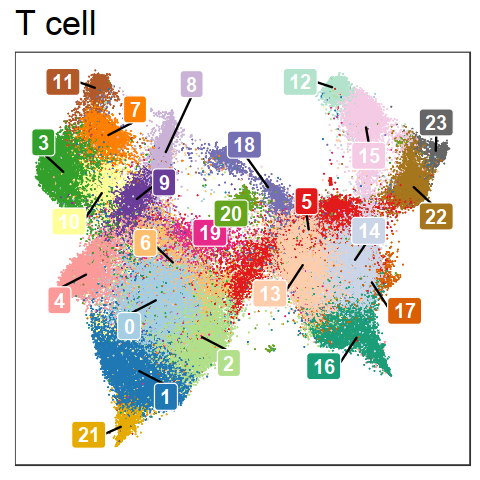

In [32]:
# Plot clusters

meta_umap$cluster_number <- factor(meta_umap$cluster_number, 
                                levels = seq(0, 23)
                               )
meta_umap$cluster_name <- factor(meta_umap$cluster_name, 
                                levels = c( "T-0: CD4+ IL7R+ memory", "T-1: CD4+ CD161+ memory", "T-2: CD4+ IL7R+CCR5+ memory", "T-3: CD4+ Tfh/Tph", "T-4: CD4+ naive",
                                            "T-5: CD4+ GZMK+ memory", "T-6: CD4+ memory", "T-7: CD4+ Tph", "T-8: CD4+ CD25-high Treg", "T-9: CD4+ CD25-low Treg",
                                            "T-10: CD4+ OX40+NR3C1+", "T-11: CD4+ CD146+ memory", "T-12: CD4+ GNLY+", "T-13: CD8+ GZMK/B+ memory", "T-14: CD8+ GZMK+ memory",
                                            "T-15: CD8+ GZMB+/TEMRA", "T-16: CD8+ CD45ROlow/naive", "T-17: CD8+ activated/NK-like",  "T-18: Proliferating",
                                            "T-19: MT-high (low quality)", "T-20: CD38+", "T-21: Innate-like", "T-22: Vdelta1", "T-23: Vdelta2"
                                          )
                               )



cluster_center <- meta_umap %>%
                  group_by(cluster_number) %>%
                  summarise_at(vars(UMAP1, UMAP2), funs(median(., na.rm=TRUE)))
cluster_center <- as.data.frame(cluster_center)
cluster_center$cluster_number <- as.character(cluster_center$cluster_number)

options(repr.plot.height = 4, repr.plot.width = 4)
ggplot(meta_umap[sample(nrow(meta_umap)),],
       aes(x = UMAP1, y = UMAP2, fill= cluster_number)
      ) +
  geom_point_rast(size = 0.5, stroke = 0.0001, shape = 21) +
  geom_label_repel(
    data = cluster_center,
    aes(label = cluster_number, fill = cluster_number), 
    size = 4.2, 
    color = 'white',
    fontface = 'bold', 
    box.padding = unit(0.7, "lines"),
    point.padding = unit(0.2, "lines"),
    segment.color = 'black'
  ) +
  scale_fill_manual(values = c(brewer.pal(12, "Paired"), brewer.pal(4, "Pastel2"), brewer.pal(8, "Dark2")), name = "") + 
  guides( fill = guide_legend(override.aes = list(shpae = 15, size = 2))) +
  labs(
      x = NULL,
      y = NULL,
      title = "T cell"
      ) +
  theme_bw(base_size = 12) +
  theme(
    legend.position = "none",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=20)
    )

ggsave(file = paste("T_umap_cluster_v3", ".pdf", sep = ""), width = 4, height = 4, dpi = 300)

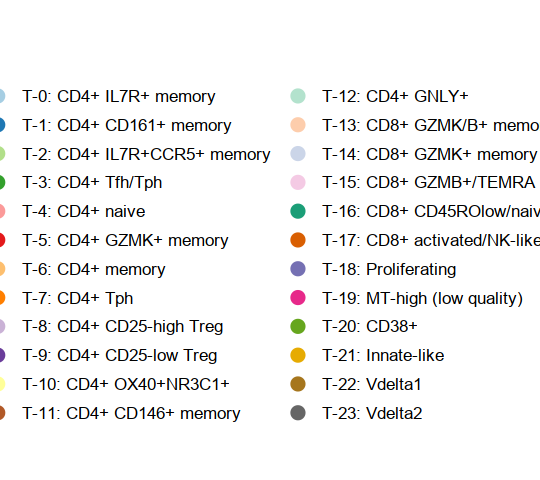

In [7]:
options(repr.plot.height = 4, repr.plot.width = 4.5)
p <- ggplot(meta_umap[sample(nrow(meta_umap)),],
       aes(x = UMAP1, y = UMAP2, fill= cluster_name)
      ) +
  geom_point(size = 0.5, stroke = 0.0001, shape = 21) +
  scale_fill_manual(values = c(brewer.pal(12, "Paired"), brewer.pal(4, "Pastel2"), brewer.pal(8, "Dark2")), name = "") + 
  guides( fill = guide_legend(override.aes = list(shpae = 15, size = 4))) +
  labs(
      x = NULL,
      y = NULL
      ) +
  theme_bw(base_size = 12) +
  theme(
    legend.position = "right",
    axis.text = element_blank(),
    axis.ticks = element_blank(),
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=15)
    )
legend <- cowplot::get_legend(p)
grid.draw(legend)

ggsave(file = paste("T_umap_cluster_legend", ".pdf", sep = ""), width = 4.5, height = 3, dpi = 300)

Warning message in melt(temp5):
"The melt generic in data.table has been passed a table and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(temp5). In the next version, this warning will become an error."


[1] 1944    3

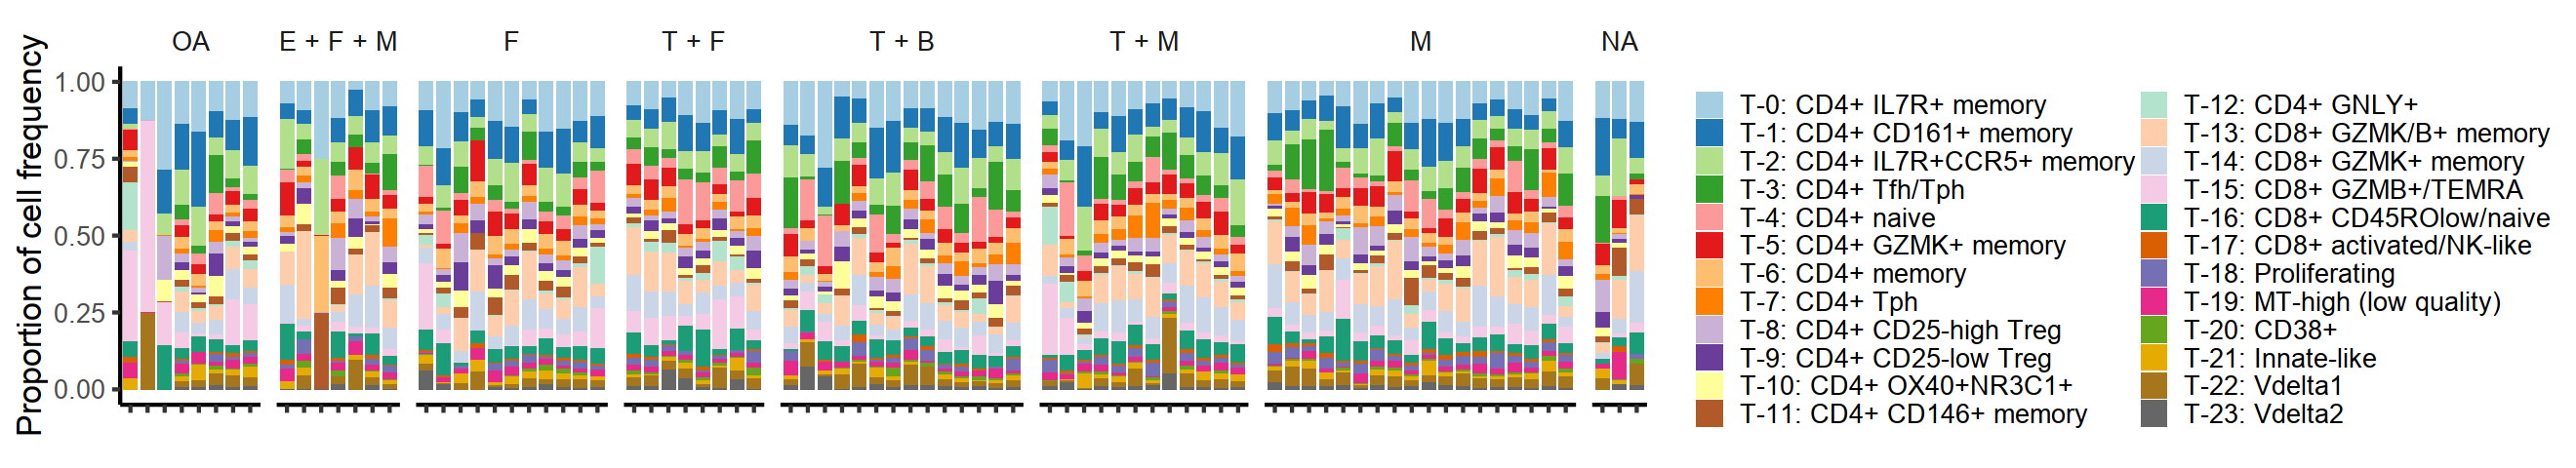

In [25]:
temp5 <- table(meta_umap$sample, meta_umap$cluster_name)
temp6 <- melt(temp5)
colnames(temp6) <- c("sample", "cluster", "freq")
hc1 <- hclust(dist(temp5))
temp6$sample <- as.factor(temp6$sample)
temp6$sample <- factor(temp6$sample, levels = rownames(temp5)[hc1$order])
temp6$cluster <- as.character(temp6$cluster)
dim(temp6)

clin <- readRDS("/data/srlab1/public/srcollab/AMP_Phase_2/singlecell_result/d_pca_category_all_2021-08-03.rds")
colnames(clin)[1] <- "sample"
temp6 <- merge(x = temp6, y = clin[, c("sample", "new_class")], by = "sample", all.x = TRUE)
oa_sample <- c("BRI-399", "BRI-438", "BRI-442", "BRI-456", "BRI-477", "BRI-487", "BRI-517", "BRI-523", "BRI-587", "BRI-609")
temp6[which(temp6$sample %in% oa_sample),]$new_class <- "OA" 
temp6$new_class <- factor(temp6$new_class, levels = c("OA", "E + F + M", "F", "T + F", "T + B", "T + M", "M"))


temp6$cluster <- factor(temp6$cluster, levels = c( "T-0: CD4+ IL7R+ memory", "T-1: CD4+ CD161+ memory", "T-2: CD4+ IL7R+CCR5+ memory", "T-3: CD4+ Tfh/Tph", "T-4: CD4+ naive",
                                            "T-5: CD4+ GZMK+ memory", "T-6: CD4+ memory", "T-7: CD4+ Tph", "T-8: CD4+ CD25-high Treg", "T-9: CD4+ CD25-low Treg",
                                            "T-10: CD4+ OX40+NR3C1+", "T-11: CD4+ CD146+ memory", "T-12: CD4+ GNLY+", "T-13: CD8+ GZMK/B+ memory", "T-14: CD8+ GZMK+ memory",
                                            "T-15: CD8+ GZMB+/TEMRA", "T-16: CD8+ CD45ROlow/naive", "T-17: CD8+ activated/NK-like",  "T-18: Proliferating",
                                            "T-19: MT-high (low quality)", "T-20: CD38+", "T-21: Innate-like", "T-22: Vdelta1", "T-23: Vdelta2"
                                          )
                       )

options(repr.plot.height = 4, repr.plot.width = 22)
ggplot(
      temp6,
      aes(x = sample, y=freq, fill = cluster)
      ) + 
    geom_bar(stat = "identity", 
             position = "fill", 
             width = 0.8) +
  facet_grid(cols = vars(new_class), scales = "free_x", space = "free_x") +
  scale_fill_manual(values = c(brewer.pal(12, "Paired"), brewer.pal(4, "Pastel2"), brewer.pal(8, "Dark2")), name = "") + 
  labs(x = "", y = "Proportion of cell frequency") + 
  theme_classic(base_size = 20) +
  theme(
#     legend.position = "none",
        strip.background = element_blank(),
#         strip.text.y = element_blank(),
        axis.text.x = element_blank(),
        panel.grid = element_blank()
  ) 
ggsave(file = paste("tcell_barplot", ".pdf", sep = ""), width = 22, height = 4, dpi = 300)

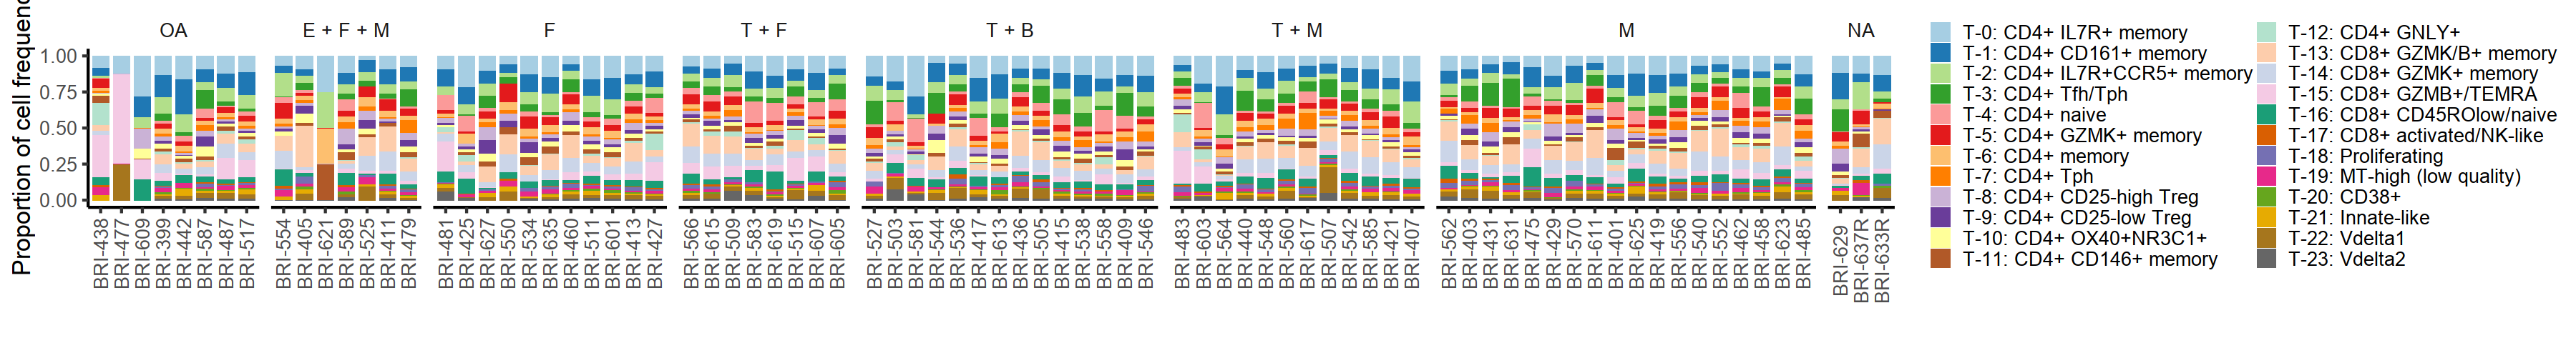

In [19]:
options(repr.plot.height = 4, repr.plot.width = 30)
ggplot(
      temp6,
      aes(x = sample, y=freq, fill = cluster)
      ) + 
    geom_bar(stat = "identity", 
             position = "fill", 
             width = 0.8) +
  facet_grid(cols = vars(new_class), scales = "free_x", space = "free_x") +
  scale_fill_manual(values = c(brewer.pal(12, "Paired"), brewer.pal(4, "Pastel2"), brewer.pal(8, "Dark2")), name = "") + 
  labs(x = "", y = "Proportion of cell frequency") + 
  theme_classic(base_size = 20) +
  theme(
#     legend.position = "none",
        strip.background = element_blank(),
#         strip.text.y = element_blank(),
#         axis.text.x = element_blank(),
        axis.text.x = element_text(angle = 90, vjust = 0.5),
        panel.grid = element_blank()
  ) 

In [27]:
scale_rows <- function(x) t(scale(t(x)))

# Plot rowscale Z-score of percent of cells

In [45]:
d <- melt(table(meta_umap$sample, meta_umap$cluster_name))
colnames(d) <- c("donor", "cluster_name", "cells")
d_perc <- d %>%
  group_by(donor) %>%
  dplyr::summarise(cluster_name = cluster_name,
                   num_cell = sum(cells),
                   perc = cells/num_cell )
d$perc_donor <- d_perc$perc
sum(d_perc[which(d_perc$donor == "BRI-399"),]$perc)

mat <- dcast(data = d_perc, formula = cluster_name ~ donor, value.var = "perc")
rownames(mat) <- mat$cluster_name
mat <- mat[, -1]
colSums(mat)

Warning message in melt(table(meta_umap$sample, meta_umap$cluster_name)):
"The melt generic in data.table has been passed a table and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(table(meta_umap$sample, meta_umap$cluster_name)). In the next version, this warning will become an error."
`summarise()` has grouped output by 'donor'. You can override using the `.groups` argument.



[1] 1

Warning message in dcast(data = d_perc, formula = cluster_name ~ donor, value.var = "perc"):
"The dcast generic in data.table has been passed a grouped_df and will attempt to redirect to the reshape2::dcast; please note that reshape2 is deprecated, and this redirection is now deprecated as well. Please do this redirection yourself like reshape2::dcast(d_perc). In the next version, this warning will become an error."


BRI-399  BRI-401  BRI-403  BRI-405  BRI-407  BRI-409  BRI-411  BRI-413 
       1        1        1        1        1        1        1        1 
 BRI-415  BRI-417  BRI-419  BRI-421  BRI-425  BRI-427  BRI-429  BRI-431 
       1        1        1        1        1        1        1        1 
 BRI-436  BRI-438  BRI-440  BRI-442  BRI-458  BRI-460  BRI-462  BRI-475 
       1        1        1        1        1        1        1        1 
 BRI-477  BRI-479  BRI-481  BRI-483  BRI-485  BRI-487  BRI-503  BRI-505 
       1        1        1        1        1        1        1        1 
 BRI-507  BRI-509  BRI-511  BRI-515  BRI-517  BRI-525  BRI-527  BRI-534 
       1        1        1        1        1        1        1        1 
 BRI-536  BRI-538  BRI-540  BRI-542  BRI-544  BRI-546  BRI-548  BRI-550 
       1        1        1        1        1        1        1        1 
 BRI-552  BRI-554  BRI-556  BRI-558  BRI-560  BRI-562  BRI-564  BRI-566 
       1        1        1        1        1        1        1        1 
 BRI-570  BRI-581  BRI-583  BRI-585  BRI-587  BRI-589  BRI-601  BRI-603 
       1        1        1        1        1        1        1        1 
 BRI-605  BRI-607  BRI-609  BRI-611  BRI-613  BRI-615  BRI-617  BRI-619 
       1        1        1        1        1        1        1        1 
 BRI-621  BRI-623  BRI-625  BRI-627  BRI-629  BRI-631 BRI-633R  BRI-635 
       1        1        1        1        1        1        1        1 
BRI-637R 
       1

In [7]:
meta_colors$cluster_color <- c(
    'CD4+ IL7R+ memory: T-0' = "#A6CEE3",
    'CD4+ CD161+ memory: T-1'= "#1F78B4",
    'CD4+ IL7R+CCR5+ memory: T-2'= "#B2DF8A",
    'CD4+ Tfh/Tph: T-3'= "#33A02C",
    'CD4+ naive: T-4'= "#FB9A99",
    'CD4+ GZMK+ memory: T-5'= "#E31A1C",
    'CD4+ memory: T-6'= "#FDBF6F",
    'CD4+ Tph: T-7'= "#FF7F00",
    'CD4+ CD25-high Treg: T-8'= "#CAB2D6",
    'CD4+ CD25-low Treg: T-9'= "#6A3D9A",
    'CD4+ OX40+NR3C1+: T-10'= "#FFFF99",
    'CD4+ CD146+ memory: T-11'= "#B15928",
    'CD4+ GNLY+: T-12'= "#B3E2CD",
    'CD8+ GZMK/B+ memory: T-13'= "#FDCDAC",
    'CD8+ GZMK+ memory: T-14'= "#CBD5E8",
    'CD8+ GZMB+/TEMRA: T-15'= "#F4CAE4",
    'CD8+ CD45ROlow/naive: T-16'= "#1B9E77",
    'CD8+ activated/NK-like: T-17'= "#D95F02",
    'Proliferating: T-18'= "#7570B3",
    'MT-high (low quality): T-19'= "#E7298A",
    'CD38+: T-20'= "#66A61E",
    'Innate-like: T-21'= "#E6AB02",
    'Vdelta1: T-22' = "#A6761D",
    'Vdelta2: T-23'= "#666666"
)


In [8]:
# Overwrite default draw_colnames in the pheatmap package.
# Thanks to Josh O'Brien at http://stackoverflow.com/questions/15505607
draw_colnames_45 <- function (coln, gaps, ...) {
    coord <- pheatmap:::find_coordinates(length(coln), gaps)
    x     <- coord$coord - 0.5 * coord$size
    res   <- grid::textGrob(
      coln, x = x, y = unit(1, "npc") - unit(3,"bigpts"),
      vjust = 0.75, hjust = 1, rot = 45, gp = grid::gpar(...)
    )
    return(res)
}
assignInNamespace(
  x = "draw_colnames",
  value = "draw_colnames_45",
  ns = asNamespace("pheatmap")
)
for (i in dev.list()[1]:dev.list()[length(dev.list())]) {
   dev.off()
}

In [ ]:
library(stringr)
mat_z_class <- as.data.frame(t(mat_z))
mat_z_class$new_class <- annotation_col$new_class

mat_z_mean <- mat_z_class %>%
              group_by(new_class) %>%
              summarise_all("mean")
mat_z_mean <- as.data.frame(t(mat_z_mean))
colnames(mat_z_mean) <- as.character(t(mat_z_mean[1,]))
mat_z_mean <- mat_z_mean[-1,]
row_name <- rownames(mat_z_mean)
row_name <- paste0(sub('.*: ', "", rownames(mat_z_mean)), ": ", sub("\\:.*", "", rownames(mat_z_mean)), sep = "")
col_name <- colnames(mat_z_mean)
mat_z_mean <- data.frame(apply(mat_z_mean, 2, function(x) as.numeric(as.character(x))))
colnames(mat_z_mean) <- col_name
rownames(mat_z_mean) <- row_name            
                               
annot_row = data.frame(
    cluster_color = rownames(mat_z_mean)
)
annot_row$cluster_color <- as.character(annot_row$cluster_color)
rownames(annot_row) <- annot_row$cluster_color
     
annot_col = data.frame(
    new_class = colnames(mat_z_mean)
)
annot_col$new_class <- as.character(annot_col$new_class)  
# rownames(annot_col) <-  as.character(annot_col$new_class)  


options(repr.plot.height = 7, repr.plot.width = 15)
# Create pheatmap in PDF file!
filename <- "heatmap_rowscale_tcell_cluster_mean.pdf"
hm.parameters <- list(
          mat = mat_z_mean[, -ncol(mat_z_mean)], 
          breaks =  seq(-max(mat_z_mean), max(mat_z_mean), 0.1), # mat_breaks,
          color  = colorRampPalette(rev(brewer.pal(n=9,name="RdBu")))(2*max(mat_z_mean)/0.1), # scico(30, palette = 'vik'),
          border_color = NA,
          cellwidth = 20, cellheight = 14,
#           annotation_col    = annot_col,
          annotation_row    = annot_row,
          annotation_colors = meta_colors,
          show_rownames = TRUE,
          show_colnames = TRUE,
          cluster_rows = FALSE,
          cluster_cols = FALSE,
          fontsize = 12,
          fontsize_row = 12
        )
 
  # To draw the heat map on screen 
  do.call("pheatmap", hm.parameters)
 
  # To draw to file 
  do.call("pheatmap", c(hm.parameters, filename=filename))

# Pseudobulk analysis

In [11]:
# Generate pseudobulk matrix
exprs_raw <- mRNA_exprs[, meta_data$cell]
all(colnames(exprs_raw) == meta_data$cell)
dim(exprs_raw)

all_collapse <- collapse_counts(exprs_raw, meta_data, c("cluster_number", "sample"))

# For the purpose of future visualization at per-cell level
exprs_norm <- exprs_raw %>% NormalizeDataSeurat()

rm(mRNA_exprs)
rm(exprs_raw)

[1] TRUE

[1] 33538 94056

In [86]:
# Normalize pseudobulk matrix
cutoff <- 30
drop <- which(apply(all_collapse$counts_mat, 1, max) < cutoff)
d <- all_collapse$counts_mat[-drop,]
dim(d)
tmp <- log2(cpm(d)+1)

[1] 10104  1799

In [8]:
group <- interaction(all_collapse$meta_data$cluster_number)
cell_umi <- apply(all_collapse$counts_mat, 2, function(x) {log2(sum(x) + 1)})
donor <- interaction(all_collapse$meta_data$sample)

mm <- model.matrix(~0 + group + donor + cell_umi)
colnames(mm) <- gsub("-", ".", colnames(mm))

In [9]:
# Diferential expression for one gene
diffexp_lm <- function(gexp, gname, min_clus, max_clus, mm) {
    Reduce(rbind, lapply(min_clus:max_clus, function(x) {
        m <- lm(gexp~., data = data.frame(mm[,colnames(mm) == paste0("group", x) | !grepl("group", colnames(mm))]))
        m_null <- lm(gexp~., data = data.frame(mm[,!grepl("group", colnames(mm))]))

        m_chisq <- anova(m_null, m, test = "LRT")
        m_f <- anova(m_null, m, test = "F")
        m_f_var <- anova(m, test = "F")
        c(summary(m)$coefficients[2,], m_chisq$`Sum of Sq`[2], m_chisq$P[2], m_f$F[2], m_f$P[2], m_f_var$F[1], m_f_var$P[1], gname, x)
    }))
}

,gene.mean,gene.dispersion
,<dbl>,<dbl>
AL669831.5,3.910024,6.367626
NOC2L,5.575474,6.825664
PLEKHN1,3.729261,6.333984
AL645608.8,1.511469,4.742243


[1] 2248

[1] 6 7 8 9

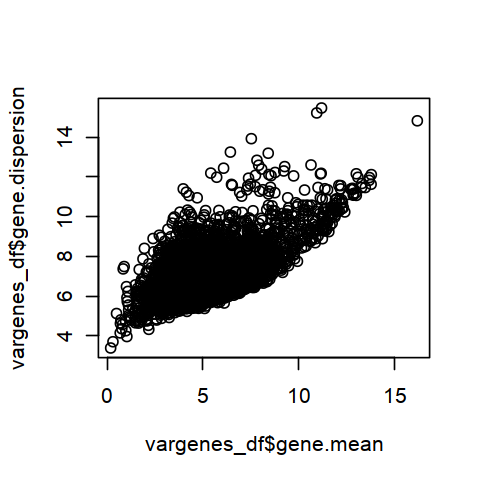

In [90]:
# Find varible genes to further identify most differential expressed genes in the next step
genes_exclude <- grep("^MT-|^RPL|^RPS|MALAT1|MIR-", row.names(tmp), value = TRUE)
vargenes_df <- FindVariableGenesSeurat(tmp, meta_data, genes_exclude, 1e3)
vargenes_df[1:4, ]
plot(vargenes_df$gene.mean, vargenes_df$gene.dispersion)
varg <- which(vargenes_df$gene.dispersion > 6 & vargenes_df$gene.mean > 6)
length(varg)
varg[1:4]

In [ ]:
# Run it on all or a subset of genes
results <- Reduce(rbind, lapply(varg, function(x) {
    diffexp_lm(tmp[x,], row.names(tmp)[x], 0, 23, mm)}
))
saveRDS(results, "pseudobulk_tcell.rds")

In [5]:
# Load tcell cluster genes
results <- readRDS("pseudobulk_tcell.rds")
dim(results)

[1] 53952    12

In [6]:
# Organize the results
dim(results)
results_temp <- results[, c(1,2,3,4, ncol(results)-1, ncol(results))]
colnames(results_temp) <- c("Estimate", "Std_error", "t_value", "p_value", "gene", "cluster_number")
rownames(results_temp) <- seq(1, nrow(results_temp))
results_temp <- as.data.frame(results_temp)
table(results_temp$cluster_number)
results_temp <- cbind(lapply(results_temp[, c(1:4)], function(x) as.numeric(as.character(x))), results_temp[, c(5,6)])
results_temp$log_p_value <- -log10(results_temp$p_value)
results_temp[1:4,]

[1] 53952    12


   0    1   10   11   12   13   14   15   16   17   18   19    2   20   21   22 
2248 2248 2248 2248 2248 2248 2248 2248 2248 2248 2248 2248 2248 2248 2248 2248 
  23    3    4    5    6    7    8    9 
2248 2248 2248 2248 2248 2248 2248 2248 

,Estimate,Std_error,t_value,p_value,gene,cluster_number,log_p_value
,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>
1,-0.6521206,0.2106314,-3.096028,0.001993042,ISG15,0,2.7004835
2,-0.2242438,0.2131123,-1.052233,0.292840751,ISG15,1,0.5333685
3,-0.4733889,0.2073217,-2.283355,0.022531230,ISG15,2,1.6472151
4,-0.6124204,0.2117011,-2.892853,0.003865735,ISG15,3,2.4127679


In [6]:
# Select the most significant results
p_thresh <- 0.05/ (length(varg)*length(names(table(meta_data$cluster_number))))
p_thresh
results_good <- results_temp[which(results_temp$log_p_value > -log10(p_thresh * 10) & results_temp$Estimate > 1.5),]

# Visualize pseudobulk genes in heatmap

In [15]:
# gene_plot <- unique(results_good$gene)
gene_plot <- c("ANK3", "CD40LG", "IL7R", "LTB", "AQP3", "NFKB1", "GATA3", "CRIP2", "CCR6",
              "KLRB1", "TCF7", "AREG", "MAL", "CCR7", "SELL", "NOSIP", "LDHB", "FOXP1", "TIGIT",
               "ICOS", "IL6ST", "TSHZ2", "SESN3", "TBC1D4", "CCR4", "IL2RA", "RTKN2", "FOXP3", "CD4",
              "CTLA4", "TNFRSF4", "TNFRSF18", "LAIR2", "PDCD1", "CXCL13", "CXCR3", "COTL1", "GYPC",
              "PTPN6", "NUCB2", "NUCB2", "HLA-DQA1", "HLA-DRA", "DENND2D", "IGHG3", "IGHG1", "BRD7",
              "STMN1", "CENPF", "MKI67", "TPSB2", "TPSAB1", "GZMK", "GZMA", "CCL5", "CCL4L2", "YBX3",
              "CRTAM", "XCL2", "XCL1", "IFNG", "ZEB2", "CCL3", "CCL4", "NKG7", "PRF1", "PLEK", "GZMB",
              "TRGC2", "KLRD1", "PLAC8", "TBX21", "GNLY", "FGFBP2", "ZBTB16", "TRGC1", "TRDC", "IL21")

gene_plot <- unique(gene_plot)
length(gene_plot)

exp_heat <- exprs_norm[gene_plot,]
exp_heat <- as.data.frame(t(exp_heat))
exp_heat$cluster_name <- as.character(meta_data$cluster_name)
dim(exp_heat)

exp_ave <- aggregate(exp_heat[, 1:(ncol(exp_heat)-1)], list(exp_heat$cluster_name), mean)
colnames(exp_ave)[1] <- "cluster_name"
exp_ave <- as.data.frame(t(exp_ave))
colnames(exp_ave) <- as.character(t(exp_ave[1,]))
exp_ave <- exp_ave[-1,]
row_names <- rownames(exp_ave)

exp_ave <- mutate_all(exp_ave, function(x) as.numeric(as.character(x)))
rownames(exp_ave) <- row_names
exp_ave <- as.matrix(exp_ave)
scale_rows <- function(x) t(scale(t(x)))
exp_ave_scale <- scale_rows(exp_ave) # Z-score
exp_ave_scale[exp_ave_scale > 2] <- 2
exp_ave_scale[exp_ave_scale < -2] <- -2
dim(exp_ave_scale)

[1] 77

[1] 94056    78

[1] 77 24

In [203]:
## Save genes and statistics into a table

result_save <- result_save %>% group_by(cluster_number) %>% top_n(n=10) %>% arrange(desc(Estimate))
dim(result_save)

result_save <- result_save[, c("cluster_number", "cluster_name", "gene", "Estimate", "p_value")]
result_save <- result_save[order(result_save$cluster_number),]
result_save[, 4] <- round(result_save[, 4], digits = 2)

colnames(result_save) <- c("Cluster number", "Cluster annotation", "Gene", "FC", "Likelihood ratio test p-value")
dim(result_save)
result_save[1:10,]

saveRDS(result_save, "Tcell_cluster_marker_gene.rds")

[1] 483   7

Selecting by log_p_value



[1] 208   7

[1] 1.506973e-06

[1] 1.5


 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 
 3  4  2 10  7 10  7 10 10 10 10 10 10 10 10 10 10 10 10 10  5 10 10 10 

[1] 208   5

,Cluster number,Cluster annotation,Gene,FC,Likelihood ratio test p-value
,<dbl>,<chr>,<fct>,<dbl>,<dbl>
1,0,CD4+ IL7R+ memory,MAL,1.95,2.284847e-10
2,0,CD4+ IL7R+ memory,CD40LG,1.65,1.388003e-07
3,0,CD4+ IL7R+ memory,IL7R,1.51,2.601245e-10
4,1,CD4+ CD161+ memory,KLRB1,3.56,3.451044e-24
5,1,CD4+ CD161+ memory,CD40LG,2.01,1.910204e-10
6,1,CD4+ CD161+ memory,PLAC8,1.66,7.373522e-09
7,1,CD4+ CD161+ memory,MAL,1.65,1.154435e-07
8,2,CD4+ IL7R+CCR5+ memory,CD40LG,2.03,3.517840e-11
9,2,CD4+ IL7R+CCR5+ memory,CD4,1.52,1.401008e-06


In [ ]:
subset <- which(rownames(exp_ave_scale) %in% rownames(exp_ave_scale)) 
labels = rownames(exp_ave_scale)[subset]
col_fun <- scico(10, palette = 'vik') # 'bamako'

pdf("tcell_heatmap.pdf", width = 8, height = 16)
Heatmap(exp_ave_scale, 
        col = col_fun,
        row_names_gp = gpar(fontsize = 18),
        column_km = 4,
        column_names_rot = 45,
        cluster_rows = TRUE,
        cluster_columns = TRUE,
        show_column_names = TRUE,
        show_row_names = FALSE, 
        show_row_dend = FALSE, 
        show_column_dend = FALSE
       ) +
rowAnnotation(link = row_anno_link(at = subset, labels = labels),
              width = unit(1, "cm") + 
              max_text_width(labels)
             )
dev.off()


Warning message:
"anno_link() is deprecated, please use anno_mark() instead."


# Visualize protein expressions in umap

In [119]:
# Load filtered proteins
# 1. CLR normalized protein expression: /data/srlab/fzhang/amp/results/2020_01_22_AMP_cite_seq_QC/adt_exprs_norm_2020-01-25.rds
# 2. Remove background based on global gaussian mixture model: /data/srlab/fzhang/amp/results/2020_01_22_AMP_cite_seq_QC/adt_exprs_norm_filter_2020-02-18.rds
adt_exprs <- readRDS("/data/srlab/fzhang/amp/results/2020_01_22_AMP_cite_seq_QC/adt_exprs_norm_filter_2020-02-18.rds")
adt_exprs <- adt_exprs[, meta_data$cell]
dim(adt_exprs)
rownames(adt_exprs) <- substr(rownames(adt_exprs),1,nchar(rownames(adt_exprs))-5) 
rownames(adt_exprs)

[1]    58 94056

[1] "CD107a/LAMP1"                  "CD112/Nectin-2"               
 [3] "CD119/IFN-gamma-R-alpha-chain" "CD11b"                        
 [5] "CD11c"                         "CD127/IL-7R-alpha"            
 [7] "CD140a/PDGFR-alpha"            "CD141/Thrombomodulin"         
 [9] "CD144/VE-Cadherin"             "CD146"                        
[11] "CD14"                          "CD155/PVR"                    
[13] "CD161"                         "CD163"                        
[15] "CD16"                          "CD192/CCR2"                   
[17] "CD195/CCR5"                    "CD196/CCR6"                   
[19] "CD19"                          "CD1c"                         
[21] "CD206/MMR"                     "CD209/DC-SIGN"                
[23] "CD20"                          "CD21"                         
[25] "CD226/DNAM-1(11A8)"            "CD24"                         
[27] "CD273/B7-DC/PD-L2"             "CD274/B7-H1/PD-L1"            
[29] "CD278/ICOS"                    "CD279/PD-1"                   
[31] "CD27(LG.3A10)"                 "CD304/Neuropilin-1"           
[33] "CD309/VEGFR2"                  "CD314/NKG2D"                  
[35] "CD31"                          "CD34"                         
[37] "CD38(HIT2)"                    "CD3"                          
[39] "CD44"                          "CD45(2D1)"                    
[41] "CD45RA"                        "CD45RO"                       
[43] "CD4"                           "CD55"                         
[45] "CD56/NCAM"                     "CD64"                         
[47] "CD68"                          "CD69"                         
[49] "CD86"                          "CD8a"                         
[51] "CD90/THY1"                     "CX3CR1"                       
[53] "EGFR"                          "FR-beta"                      
[55] "HLA-DR"                        "IgG-Fc"                       
[57] "IgM"                           "Podoplanin"

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

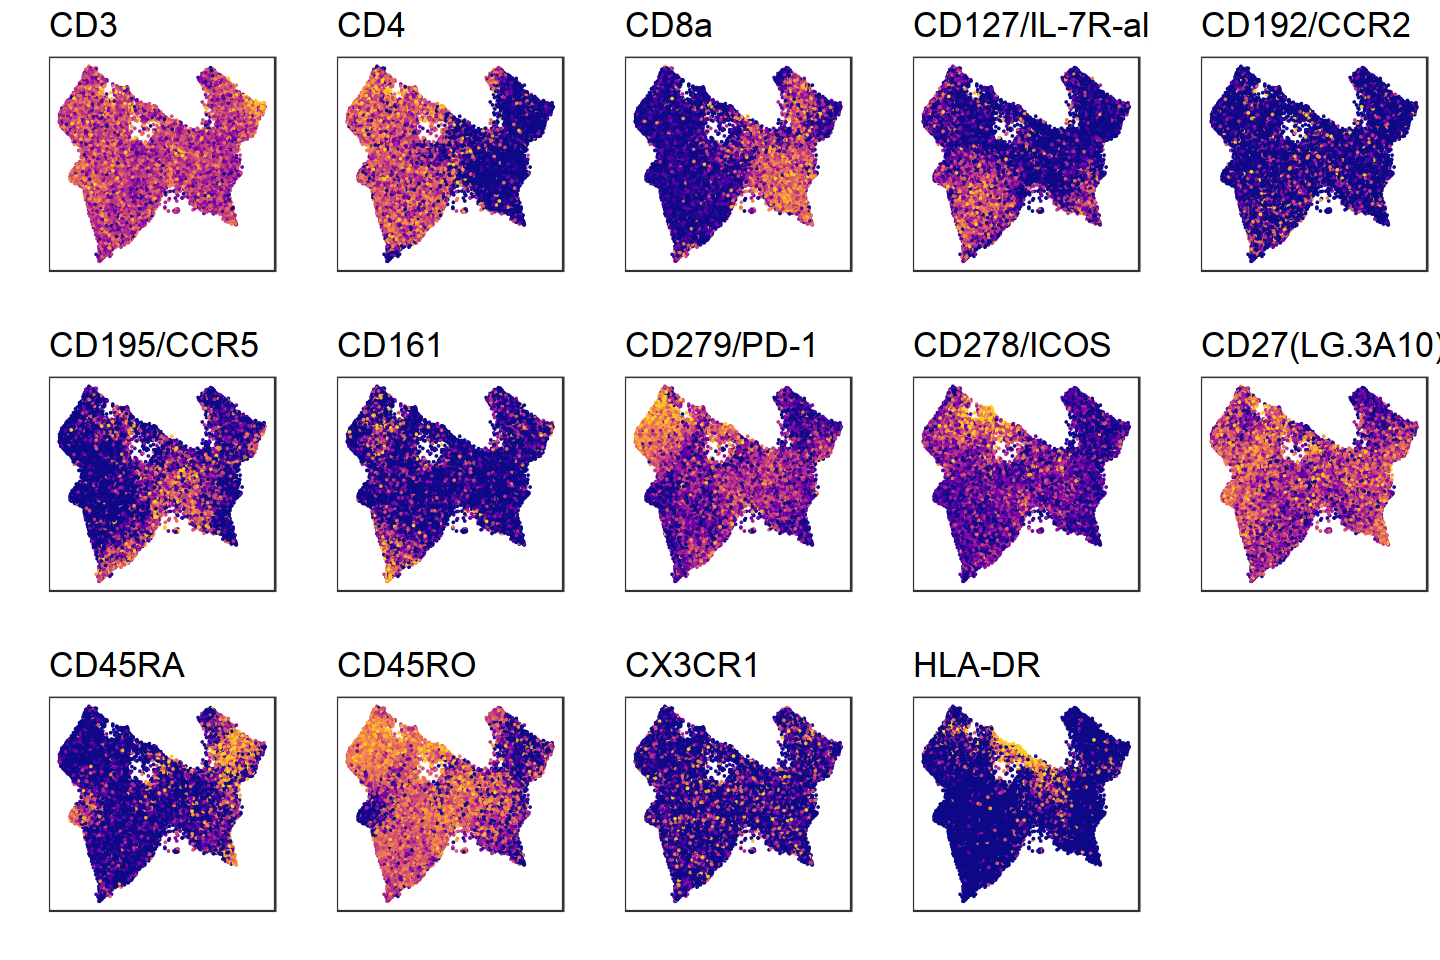

In [121]:
plot_protein <- c('CD3', 'CD4', 'CD8a', "CD127/IL-7R-alpha", "CD192/CCR2", 'CD195/CCR5', 'CD161',
                 'CD279/PD-1', 'CD278/ICOS', 'CD27(LG.3A10)', 'CD45RA', 'CD45RO', 'CX3CR1', 'HLA-DR')
plot_protein %in% rownames(adt_exprs)

myplots <- list()
for (i in 1:length(plot_protein)) {
    protein <- plot_protein[i]
    max.cutoff = quantile(adt_exprs[protein,], .99)
    min.cutoff = quantile(adt_exprs[protein,], .01)

    tmp <- sapply(X = adt_exprs[protein,], FUN = function(x) {
        return(ifelse(test = x > max.cutoff, yes = max.cutoff,
            no = x))
    })
    tmp <- sapply(X = tmp, FUN = function(x) {
        return(ifelse(test = x < min.cutoff, yes = min.cutoff,
            no = x))
    })
    meta_umap$protein <- as.numeric(tmp)
    
    ind <- paste("p", i, sep = "")
    ind <- ggplot(
                 data = meta_umap[sample(nrow(meta_umap)),],
                 aes(x = UMAP1, y = UMAP2)) + 
      geom_point(mapping = aes(color = protein), size = 0.00001) + 
      scale_color_viridis(option = "plasma", end = .9) +
      labs(x="", y="")+
      theme_bw(base_size = 15)+
      theme(
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        panel.grid = element_blank(),
        plot.title = element_text(color="black", size=20), # face="bold.italic"
        legend.position = "none") +
      labs(title = protein)
  
    myplots[[i]] <- ind
}

options(repr.plot.height = 8, repr.plot.width = 12)
p <- do.call("grid.arrange", c(myplots, ncol = 5))
ggsave(file = paste("tcell_protein_umap", ".png", sep = ""), p, width = 12, height = 8, dpi = 300)